In [2]:
import torch
import os, requests
from torch import nn
from src.model.rcnn import RCNN
from src.model import transforms
from src.config import config
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import random
import torchvision
from src.domain import pooling

import torchvision.transforms.functional as TF

# Realize predictions with square roi

In [3]:
r = requests.get( 'https://storage.googleapis.com/pd-models/RCNN_128_square_gopro.pt' )  


weights_path = 'weights.pt'
if r.status_code == 200:
    with open(weights_path, 'wb') as f:
        f.write(r.content)
else:
    print("Download failed:", r.status_code)

In [ ]:
model = RCNN(roi_res=100, pooling_type='square') # qdrl square

weights_path = 'weights.pt'
model.load_state_dict( torch.load( weights_path, map_location='cpu' ) )

/home/besttic-rd/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/besttic-rd/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [5]:
model_2 = RCNN( roi_res=100, pooling_type='qdrl' ) # qdrl square
weights_path = 'weights.pt'
model.load_state_dict( torch.load(weights_path, map_location='cpu') )

<All keys matched successfully>

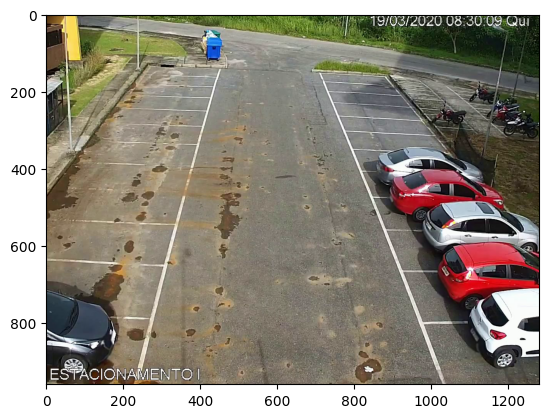

In [6]:
custum_image_path  = "/home/besttic-rd/Documents/besttic/parkOccupancy/data/camera_frame.png"
custum_image_torch = torchvision.io.read_image(custum_image_path)

plt.imshow(custum_image_torch.permute(1, 2, 0))
plt.show()

In [7]:
# load a json file

with open("/home/besttic-rd/Documents/besttic/parkOccupancy/data/parking_place_coordinates2.json") as f:
    custum_coordinates = json.load(f)

def parse_coordinates(coord_str):
    coord_str = coord_str.replace('[', '').replace(']', '')
    points = coord_str.split('), (')
    points = points[0].split(", ")
    coordinates = [[int(points[i]), int(points[i+1])] for i in range(0, len(points), 2)]
    return coordinates

split_list = [parse_coordinates(val) for _, val in custum_coordinates.items()]
print(len(split_list), split_list[0])

24 [[711, 153], [881, 162], [902, 187], [722, 175]]


In [8]:
w, h = custum_image_torch.shape[2], custum_image_torch.shape[1]
torch_tensor_coordinates = torch.tensor(split_list, dtype=torch.float32)
torch_tensor_coordinates[:, :, 0] /= (w - 1)
torch_tensor_coordinates[:, :, 1] /= (h - 1)

print(torch_tensor_coordinates.shape, custum_image_torch.shape)

w, h = custum_image_torch.shape[2], custum_image_torch.shape[1]
print(w, h) 

torch.Size([24, 4, 2]) torch.Size([3, 960, 1280])
1280 960


In [9]:
image = transforms.preprocess(custum_image_torch)
score = model(image, torch_tensor_coordinates)
custum_score = score.softmax(1)[:, 1]

list_score = [custum_score[i].item() for i in range(custum_score.shape[0])]
list_score = [ 1 if s > 0.8 else 0 for s in list_score ]
list_score

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

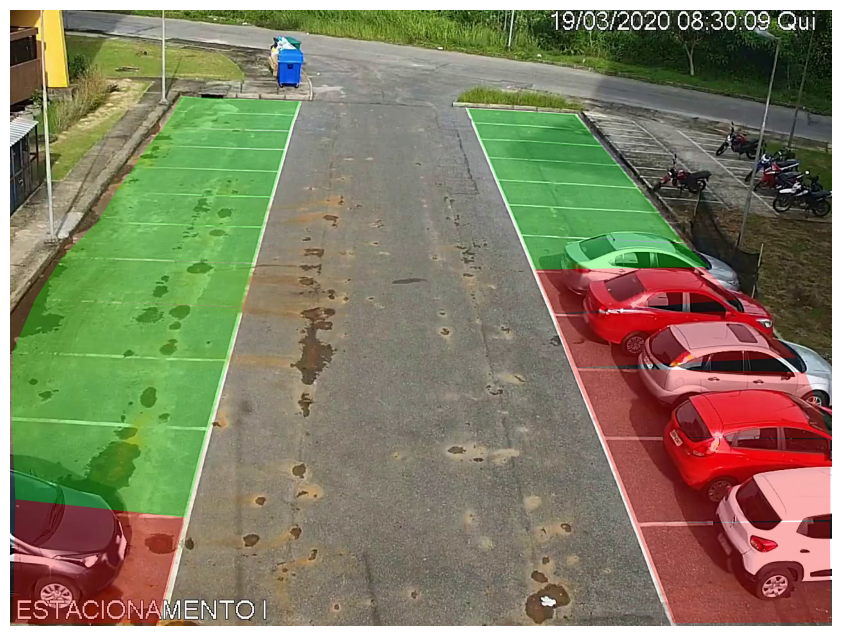

In [10]:
from src.model import visualize as vis

tensor_pred_label = torch.tensor(list_score)
vis.plot_ds_image(image, torch_tensor_coordinates, tensor_pred_label, show=True, fname="custum_image_result.png")

In [11]:

def prediction_and_visualization(image, model, threshold=0.8):

    # weights_path = 'weights.pt'
    # if not os.path.exists(weights_path):

    #     r = requests.get('https://storage.googleapis.com/pd-models/RCNN_128_square_gopro.pt')  
    #     with open( weights_path, 'wb' ) as f:
    #         f.write( r.content )
            
    # model.load_state_dict( torch.load(weights_path, map_location='cpu') )

    with open("/home/besttic-rd/Documents/besttic/parkOccupancy/data/parking_place_coordinates2.json") as f:
        coordinates = json.load(f)

    def parse_coordinates(coord_str):
        coord_str = coord_str.replace('[', '').replace(']', '')
        points = coord_str.split('), (')
        points = points[0].split(", ")
        coordinates = [[int(points[i]), int(points[i+1])] for i in range(0, len(points), 2)]
        return coordinates

    split_list = [parse_coordinates(val) for _, val in coordinates.items()]

    w, h = image.shape[2], image.shape[1]
    torch_tensor_coordinates = torch.tensor(split_list, dtype=torch.float32)
    torch_tensor_coordinates[:, :, 0] /= (w - 1)
    torch_tensor_coordinates[:, :, 1] /= (h - 1)

    image_process = transforms.preprocess( image )
    score = model(image_process, torch_tensor_coordinates)
    score = score.softmax(1)[:, 1]

    list_score = [score[i].item() for i in range(score.shape[0])]
    list_score = [ 1 if s > threshold else 0 for s in list_score ]

    tensor_pred_label = torch.tensor( list_score )
    vis.plot_ds_image(image_process, torch_tensor_coordinates, tensor_pred_label, show=True, fname=None)

    return tensor_pred_label

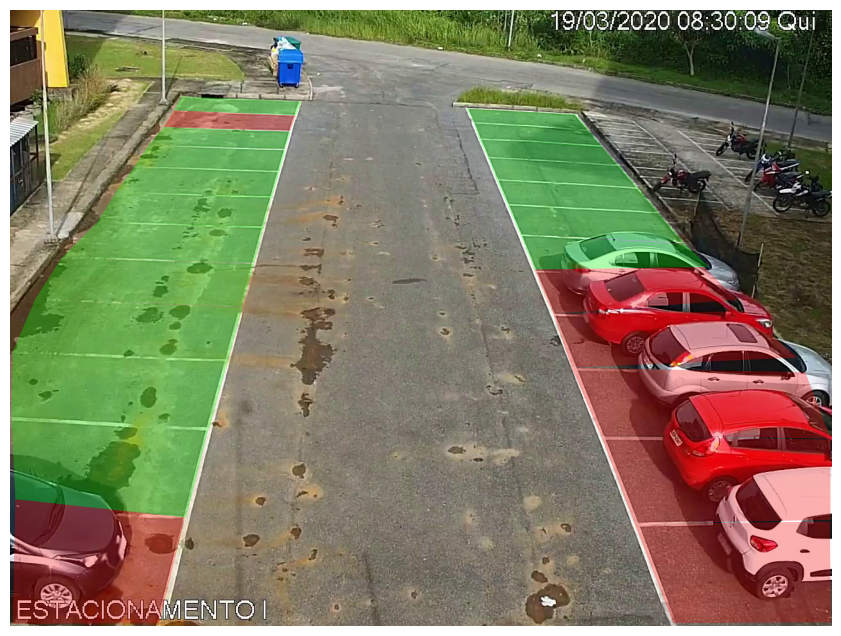

In [12]:
#weights_path = "/home/besttic-rd/Documents/besttic/parkOccupancy/src/model/RCNN_128_square_gopro.pt"

model = RCNN(roi_res=100, pooling_type='square')
model.load_state_dict(torch.load(weights_path, map_location='cpu'))

image_path = "/home/besttic-rd/Documents/besttic/parkOccupancy/data/camera_frame.png"
image = torchvision.io.read_image(custum_image_path)

tensor_pred_label = prediction_and_visualization(image, model, threshold=0.6)

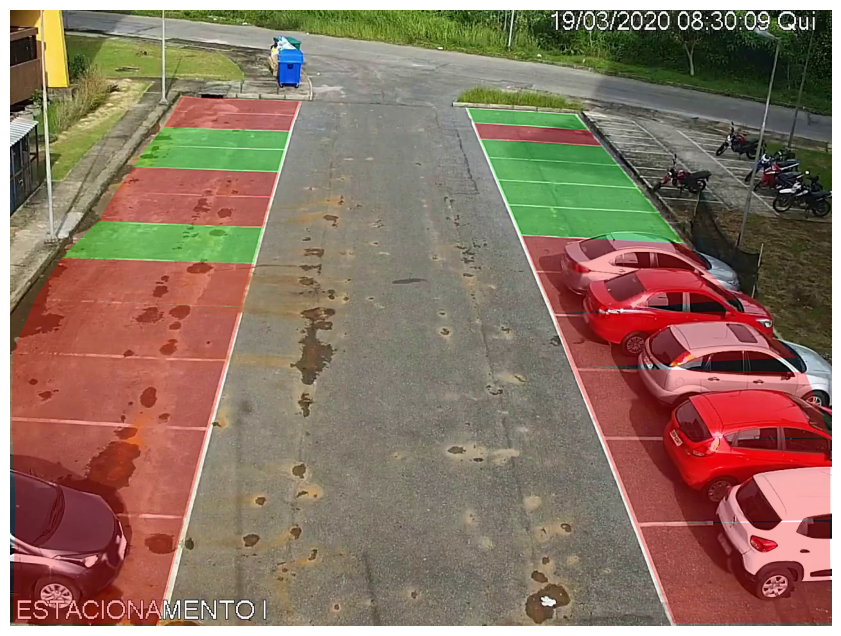

In [13]:
list_score = prediction_and_visualization(image, model_2, threshold=0.6)

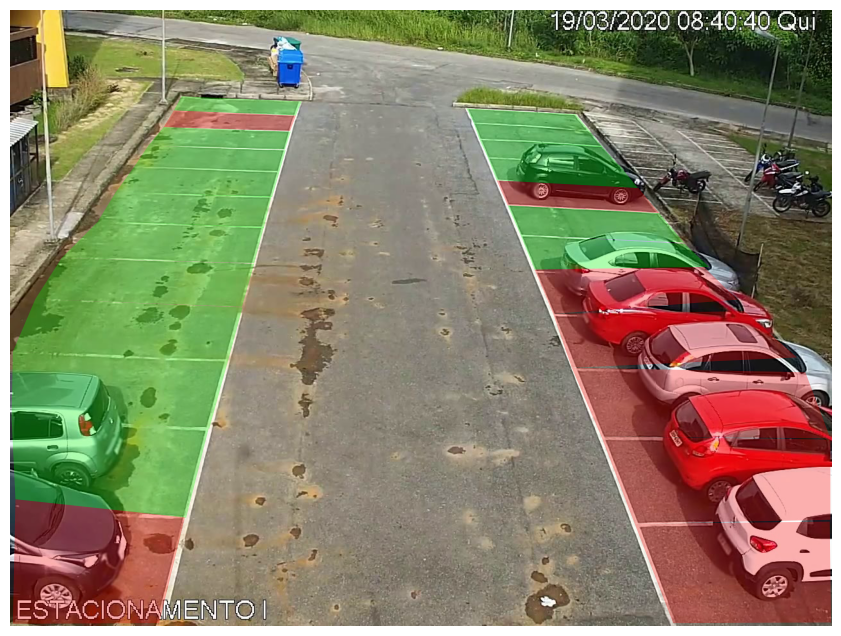

In [14]:
image_path = "/home/besttic-rd/Documents/besttic/parkOccupancy/data/camera_frame_1.png"
image1 = torchvision.io.read_image(image_path)

tensor_pred_label =prediction_and_visualization(image1, model, threshold=0.3)

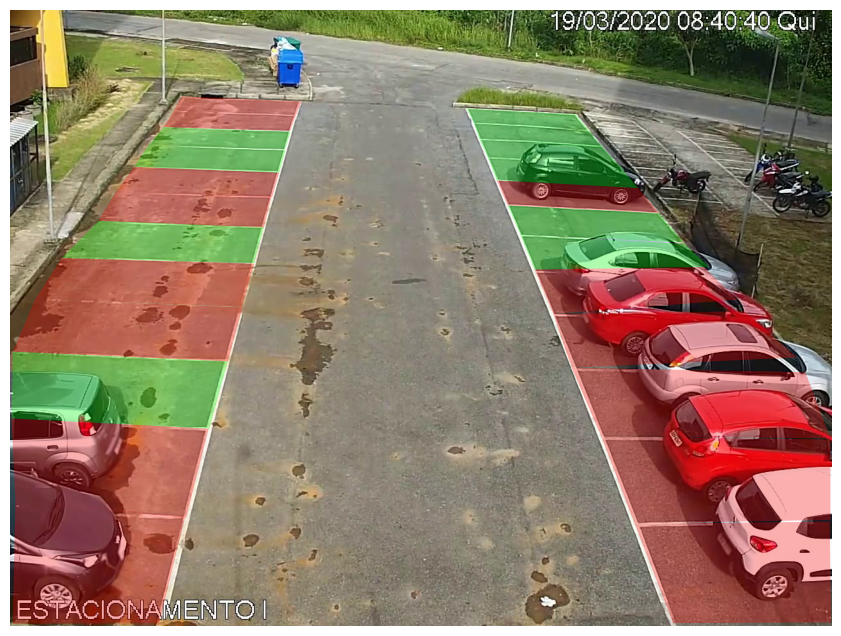

tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1])

In [15]:
prediction_and_visualization(image1, model_2, threshold=0.6)

In [16]:

image_path = "/home/besttic-rd/Documents/besttic/parkOccupancy/data/camera_frame_1.png"
image1 = torchvision.io.read_image(image_path)
image = transforms.preprocess(image1)

with open("/home/besttic-rd/Documents/besttic/parkOccupancy/data/parking_place_coordinates2.json") as f:
        coordinates = json.load(f)

def parse_coordinates(coord_str):
    coord_str = coord_str.replace('[', '').replace(']', '')
    points = coord_str.split('), (')
    points = points[0].split(", ")
    coordinates = [[int(points[i]), int(points[i+1])] for i in range(0, len(points), 2)]
    return coordinates

split_list = [parse_coordinates(val) for _, val in coordinates.items()]

w, h = image.shape[2], image.shape[1]
torch_tensor_coordinates = torch.tensor(split_list, dtype=torch.float32)
torch_tensor_coordinates[:, :, 0] /= (w - 1)
torch_tensor_coordinates[:, :, 1] /= (h - 1)

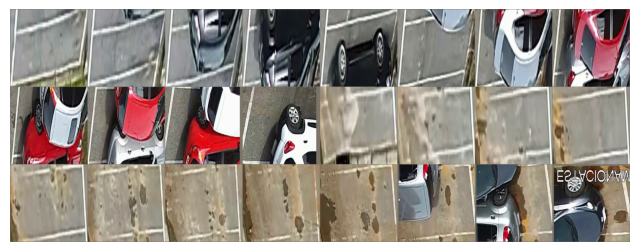

In [17]:
image_path = "/home/besttic-rd/Documents/besttic/parkOccupancy/data/camera_frame_1.png"
image_rois = torchvision.io.read_image(image_path)

image_process_roi = transforms.preprocess( image_rois )

warps_fo1 = pooling.roi_pool(image_process_roi, torch_tensor_coordinates, 500, "square") #square  "qdrl" torch_tensor_coordinates tensor_pred_label
vis.show_warps(warps_fo1)

In [18]:
type(image1)

torch.Tensor

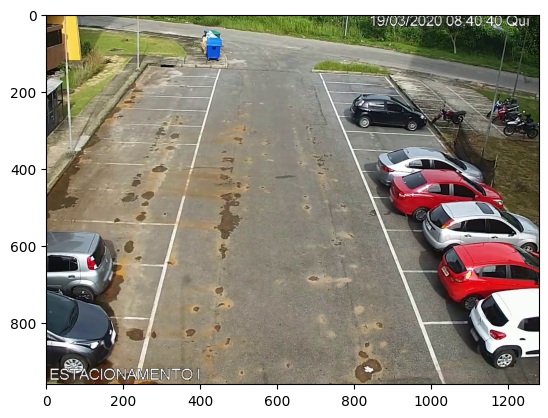

In [19]:
plt.imshow(image1.permute(1, 2, 0))
plt.show()

In [20]:
model = RCNN(roi_res=100, pooling_type='square')
model.load_state_dict( torch.load(
    "/home/besttic-rd/Documents/besttic/parkOccupancy/src/model/RCNN_128_square_gopro.pt",
    map_location='cpu') 
)
model.eval()

EOFError: 

In [21]:
from models.rcnn import RCNN
model = RCNN()

weights_path = 'weights.pt'
if not os.path.exists(weights_path):
    r = requests.get('https://storage.googleapis.com/pd-models/RCNN_128_square_gopro.pt')  
    with open(weights_path, 'wb') as f:
        f.write(r.content)
model.load_state_dict(torch.load(weights_path, map_location='cpu'))


ModuleNotFoundError: No module named 'models'

In [22]:
from src.model.rcnn import RCNN

model = RCNN()

# load model weights
weights_path = 'weights.pt'

if not os.path.exists( weights_path ):
    r = requests.get('https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2FRCNN_128_square_gopro.pt')  

    with open(weights_path, 'wb') as f:
        f.write(r.content)

model.load_state_dict( 
    torch.load(weights_path, map_location='cpu') 
)

<All keys matched successfully>